# Import libraries and load data

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier


In [2]:

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "vnstockdw",
    "user": "postgres",
    "password": "postgres"
}

table_name = "stock_history"
table_schema = "public"

conn = psycopg2.connect(**db_params)

cur = conn.cursor()

cur.execute(f"SELECT * FROM {table_name}")

rows = cur.fetchall()

col_names = [desc[0] for desc in cur.description]

stock_df = pd.DataFrame(rows, columns=col_names)

cur.close()
conn.close()

### Data columns

In [3]:
stock_df.columns

Index(['created_at', 'updated_at', 'status', 'symbol', 'open', 'high', 'low',
       'close', 'volume', 'date', 'price_change_to_1_day(s)_ago',
       'price_change_to_2_day(s)_ago', 'price_change_to_3_day(s)_ago',
       'volume_change_to_1_day(s)_ago', 'volume_change_to_2_day(s)_ago',
       'volume_change_to_3_day(s)_ago', 'price_difference',
       'median_volume_3_day(s)_periods', 'std_volume_3_day(s)_periods',
       'median_price_change_3_day(s)_periods',
       'std_price_change_3_day(s)_periods',
       'median_volume_change_3_day(s)_periods',
       'std_volume_change_3_day(s)_periods', 'sma_3_days', 'sma_5_days',
       'wma_3_days', 'wma_5_days', 'ema_3_days', 'ema_5_days',
       'bool_sma_3_days', 'bool_sma_5_days', 'bool_wma_3_days',
       'bool_wma_5_days', 'bool_ema_3_days', 'bool_ema_5_days',
       'macd_of_ema3_and_ema5', '%k_3_days', '%k_5_days', '%d_3_days',
       '%d_5_days', 'rsi_3_days', 'rsi_5_days', 'williams_%r_3_days',
       'ad_3_days', 'cci_3_days', 'b

### Data shape

In [4]:
stock_df.shape

(906, 60)

# Label Creation

* Currently using '2024-01-16' as the training dates and '2024-01-19' as the predicted dates

In [5]:
stock_df.date.value_counts()

date
2024-01-05    71
2024-01-19    69
2024-01-03    66
2024-01-12    66
2024-01-11    65
2024-01-08    65
2024-01-02    64
2024-01-04    64
2024-01-09    63
2024-01-10    63
2024-01-15    63
2024-01-18    63
2024-01-16    62
2024-01-17    62
Name: count, dtype: int64

In [6]:
stock_df['date'] = pd.to_datetime(stock_df['date'])

filtered_df = stock_df[(stock_df['date'] == '2024-01-19') | (stock_df['date'] == '2024-01-16')]

filtered_df.shape

(131, 60)

In [7]:
symbol_counts = filtered_df['symbol'].value_counts()

symbols_to_keep = symbol_counts[symbol_counts == 2].index
symbols_to_delete = symbol_counts[symbol_counts != 2].index

print("Deleted symbols:", symbols_to_delete)

filtered_df = filtered_df[filtered_df['symbol'].isin(symbols_to_keep)]

filtered_df.shape

Deleted symbols: Index(['BCF', 'ABR', 'BED', 'ALT', 'BBC', 'BAL', 'AME', 'ATB', 'ATA', 'ACM',
       'ADC', 'APT', 'AG1', 'AGF', 'AGP', 'AGX', 'ATG'],
      dtype='object', name='symbol')


(114, 60)

In [8]:
filtered_df.iloc[:5]

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_%d_5_days,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days
4,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,33000.0,33000.0,33000.0,33000.0,100.0,2024-01-16,...,1.0,-1.0,-1.0,-0.030303,0.090909,-0.030303,-100.0,0.200000,0.4,0.3
6,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,34500.0,34500.0,34500.0,34500.0,100.0,2024-01-19,...,1.0,-1.0,1.0,0.014493,0.043478,0.000000,100.0,0.166667,0.5,0.3
17,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9410.0,9500.0,9380.0,9500.0,1117000.0,2024-01-16,...,-1.0,1.0,1.0,0.010526,0.000000,0.000000,1117000.0,0.166667,0.5,0.3
20,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9570.0,9570.0,9480.0,9480.0,1902700.0,2024-01-19,...,1.0,-1.0,-1.0,-0.002110,-0.003165,-0.003165,-1902700.0,0.166667,0.5,0.3
31,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAM,9540.0,9540.0,8930.0,9200.0,1300.0,2024-01-16,...,-1.0,-1.0,-1.0,-0.036957,-0.039130,-0.039130,-1300.0,0.166667,0.5,0.3


In [9]:
close_prices_1901 = filtered_df[filtered_df['date'] == '2024-01-19'].set_index('symbol')['close']
close_prices_1601 = filtered_df[filtered_df['date'] == '2024-01-16'].set_index('symbol')['close']

labels = ((close_prices_1901 > close_prices_1601).astype(int) * 2 - 1 + 1) // 2

filtered_df['label'] = filtered_df['symbol'].map(labels)
filtered_df = filtered_df[filtered_df['date'] != '2024-01-19']

print(filtered_df.shape)
filtered_df.iloc[:5]

(57, 61)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
4,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,33000.0,33000.0,33000.0,33000.0,100.0,2024-01-16,...,-1.0,-1.0,-0.030303,0.090909,-0.030303,-100.0,0.200000,0.4,0.3,1
17,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9410.0,9500.0,9380.0,9500.0,1117000.0,2024-01-16,...,1.0,1.0,0.010526,0.000000,0.000000,1117000.0,0.166667,0.5,0.3,0
31,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAM,9540.0,9540.0,8930.0,9200.0,1300.0,2024-01-16,...,-1.0,-1.0,-0.036957,-0.039130,-0.039130,-1300.0,0.166667,0.5,0.3,0
45,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAS,8400.0,8500.0,8300.0,8500.0,705800.0,2024-01-16,...,1.0,1.0,0.023529,0.011765,0.000000,705800.0,0.166667,0.5,0.3,0
59,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAT,5370.0,5500.0,5360.0,5420.0,297700.0,2024-01-16,...,1.0,1.0,0.012915,0.022140,0.000000,297700.0,0.166667,0.5,0.3,1


# EDA?

In [10]:
num_positive = filtered_df[filtered_df["label"] == 1].shape[0]
print("Numbers of positive:", num_positive)
num_negative = filtered_df[filtered_df["label"] == -1].shape[0]
print("Numbers of negative:", num_negative)

Numbers of positive: 25
Numbers of negative: 0


# Dimensionality Reduction

# Models Training

## Split data

In [11]:
X = filtered_df.drop(columns=['label', 'created_at', 'updated_at', 'status', 'symbol', 'date'])
y = filtered_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

## Benchmark models
### Dummy model

In [12]:
dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

dummy_majority.score(X_test, y_test)

0.6

In [13]:
y_dummy_predictions = dummy_majority.predict(X_test)
print(classification_report(y_test, y_dummy_predictions, target_names=['not 1', '1']))

              precision    recall  f1-score   support

       not 1       0.33      0.38      0.35         8
           1       0.17      0.14      0.15         7

    accuracy                           0.27        15
   macro avg       0.25      0.26      0.25        15
weighted avg       0.26      0.27      0.26        15



## Decision Tree

In [14]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print("Train Accuracy:", tree_clf.score(X_train, y_train))
print("Test Accuracy:", tree_clf.score(X_test, y_test))

Train Accuracy: 1.0
Test Accuracy: 0.7333333333333333


In [15]:
tree_clf = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train)
print("Train Accuracy:", tree_clf.score(X_train, y_train))
print("Test Accuracy:", tree_clf.score(X_test, y_test))

Train Accuracy: 0.8809523809523809
Test Accuracy: 0.4


[Text(0.375, 0.9, 'x[16] <= -9800.0\ngini = 0.49\nsamples = 42\nvalue = [24, 18]'),
 Text(0.16666666666666666, 0.7, 'x[8] <= -291900.0\ngini = 0.375\nsamples = 12\nvalue = [3, 9]'),
 Text(0.08333333333333333, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.25, 0.5, 'x[48] <= 0.028\ngini = 0.18\nsamples = 10\nvalue = [1, 9]'),
 Text(0.16666666666666666, 0.3, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.3333333333333333, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.5833333333333334, 0.7, 'x[3] <= 4950.0\ngini = 0.42\nsamples = 30\nvalue = [21, 9]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6666666666666666, 0.5, 'x[16] <= 250.0\ngini = 0.375\nsamples = 28\nvalue = [21, 7]'),
 Text(0.5, 0.3, 'x[35] <= 68.328\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(0.4166666666666667, 0.1, 'gini = 0.0\nsamples = 12\nvalue = [12, 0]'),
 Text(0.5833333333333334, 0.1, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.8333333333333334, 0.3,

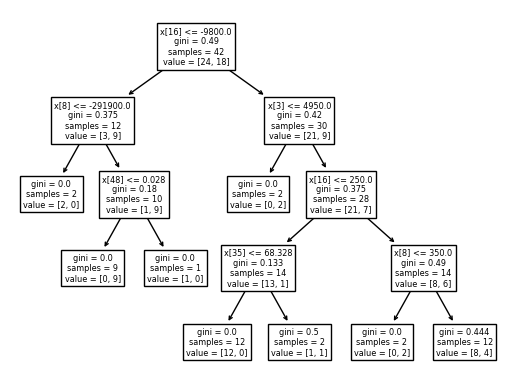

In [16]:
tree.plot_tree(tree_clf)

In [17]:
tree_predicted = tree_clf.predict(X_test)
print(classification_report(y_test, tree_predicted, target_names = ['not 1', '1']))

              precision    recall  f1-score   support

       not 1       0.45      0.62      0.53         8
           1       0.25      0.14      0.18         7

    accuracy                           0.40        15
   macro avg       0.35      0.38      0.35        15
weighted avg       0.36      0.40      0.37        15



Model AUC: 0.3839285714285714


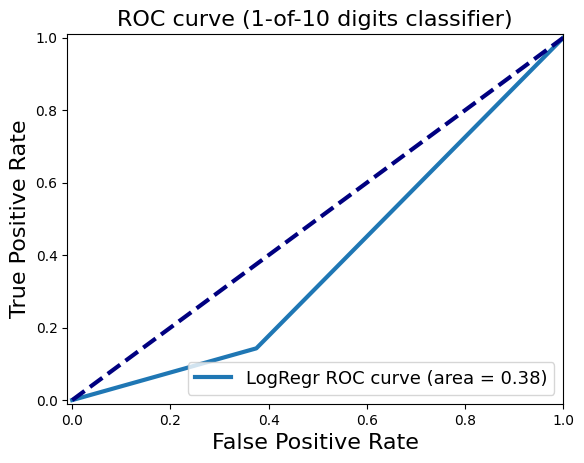

In [18]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, tree_predicted)
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("Model AUC:", roc_auc_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [19]:
cv_accuracy = cross_val_score(tree_clf, X, y, cv=5)
print('Cross-validation (accuracy):', cv_accuracy)
print('Mean Cross-validation (accuracy):', cv_accuracy.mean())

cv_auc = cross_val_score(tree_clf, X, y, cv=5, scoring='roc_auc')
print('Cross-validation (AUC):', cv_auc)
print('Mean Cross-validation (AUC):', cv_auc.mean())

cv_recall = cross_val_score(tree_clf, X, y, cv=5, scoring='recall')
print('Cross-validation (recall):', cv_recall)
print('Mean Cross-validation (recall):', cv_recall.mean())

Cross-validation (accuracy): [0.41666667 0.33333333 0.72727273 0.45454545 0.54545455]
Mean Cross-validation (accuracy): 0.4954545454545455
Cross-validation (AUC): [0.31428571 0.34285714 0.78333333 0.25       0.83333333]
Mean Cross-validation (AUC): 0.5047619047619049
Cross-validation (recall): [0.2 0.4 0.6 0.  0.4]
Mean Cross-validation (recall): 0.32


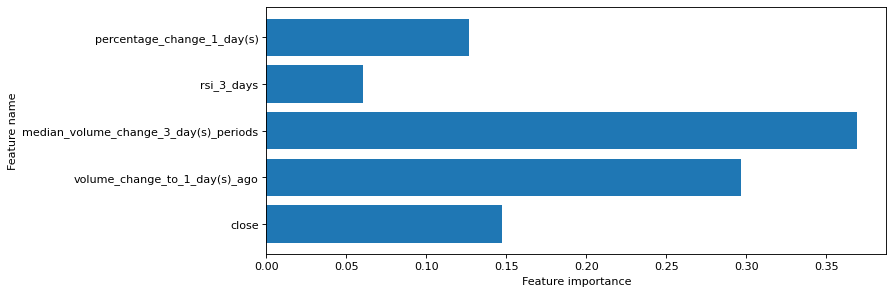

Feature importances: [0.14749164 0.29665552 0.36923077 0.06020067 0.1264214 ]


In [20]:
feature_importances = tree_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

# Random Forest

In [21]:
forest_clf = RandomForestClassifier(n_estimators = 2, max_features = 4, max_depth=2, random_state = 0)
forest_clf.fit(X_train, y_train)

print("Train Accuracy:", forest_clf.score(X_train, y_train))
print("Test Accuracy:", forest_clf.score(X_test, y_test))

y_predicted = forest_clf.predict(X_test)
print('Train set AUC: ', roc_auc_score(y_test, y_predicted))
print('Test set AUC: ', roc_auc_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted, target_names = ['not 1', '1']))

Train Accuracy: 0.7142857142857143
Test Accuracy: 0.7333333333333333
Train set AUC:  0.7410714285714286
Test set AUC:  0.7410714285714286
              precision    recall  f1-score   support

       not 1       0.83      0.62      0.71         8
           1       0.67      0.86      0.75         7

    accuracy                           0.73        15
   macro avg       0.75      0.74      0.73        15
weighted avg       0.76      0.73      0.73        15



In [22]:
cv_accuracy = cross_val_score(forest_clf, X, y, cv=5)
print('Cross-validation (accuracy):', cv_accuracy)
print('Mean Cross-validation (accuracy):', cv_accuracy.mean())

cv_auc = cross_val_score(forest_clf, X, y, cv=5, scoring='roc_auc')
print('Cross-validation (AUC):', cv_auc)
print('Mean Cross-validation (AUC):', cv_auc.mean())

cv_recall = cross_val_score(forest_clf, X, y, cv=5, scoring='recall')
print('Cross-validation (recall):', cv_recall)
print('Mean Cross-validation (recall):', cv_recall.mean())

Cross-validation (accuracy): [0.66666667 0.58333333 0.45454545 0.72727273 0.63636364]
Mean Cross-validation (accuracy): 0.6136363636363635
Cross-validation (AUC): [0.8        0.55714286 0.46666667 0.76666667 0.63333333]
Mean Cross-validation (AUC): 0.6447619047619048
Cross-validation (recall): [0.8 0.4 0.2 0.6 0.4]
Mean Cross-validation (recall): 0.48


In [23]:
grid_values = {
    'max_features': [i for i in range(1, 11)],
    'max_depth': [i for i in range(1, 5)]
}
grid_clf_auc = GridSearchCV(forest_clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.predict(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Test set AUC:  0.6607142857142857
Grid best parameter (max. AUC):  {'max_depth': 4, 'max_features': 2}
Grid best score (AUC):  0.69


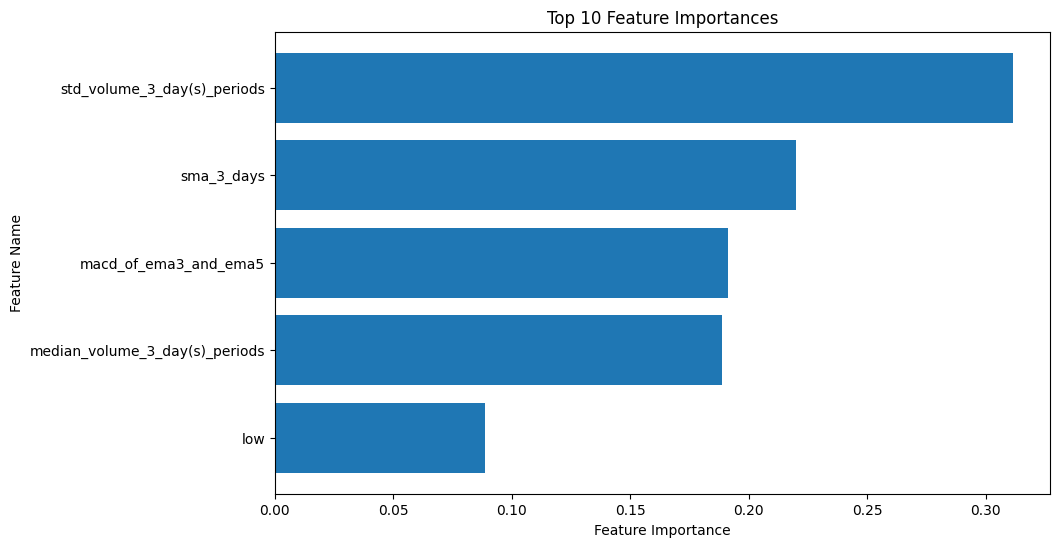

Top 10 Feature Importances:
std_volume_3_day(s)_periods: 0.3114224137931035
sma_3_days: 0.2201230873258693
macd_of_ema3_and_ema5: 0.19105842839813722
median_volume_3_day(s)_periods: 0.18857758620689646
low: 0.0888184842759935


In [24]:
feature_importances = forest_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

sorted_indices = np.argsort(non_zero_importances)[::-1]
top_10_indices = sorted_indices[:10]

top_10_importances = non_zero_importances[top_10_indices]
top_10_feature_names = non_zero_feature_names[top_10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_importances)), top_10_importances, align='center')
plt.yticks(np.arange(len(top_10_importances)), top_10_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

print('Top 10 Feature Importances:')
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f'{feature}: {importance}')

## XGBoost

In [29]:
params = {'colsample_bytree': 0.8736594686522676, 'gamma': 0.21923706150904348, 'learning_rate': 0.23160784058855982, 'max_depth': 4, 'n_estimators': 124, 'subsample': 0.6620166466910976}
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0, **params)
xgb_clf.fit(X_train, y_train)

print("Train Accuracy:", xgb_clf.score(X_train, y_train))
print("Test Accuracy:", xgb_clf.score(X_test, y_test))

y_predicted = xgb_clf.predict(X_test)

print('Train set AUC: ', roc_auc_score(y_test, y_predicted))
print('Test set AUC: ', roc_auc_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted, target_names = ['not 1', '1']))

Train Accuracy: 1.0
Test Accuracy: 0.4666666666666667
Train set AUC:  0.4464285714285714
Test set AUC:  0.4464285714285714
              precision    recall  f1-score   support

       not 1       0.50      0.75      0.60         8
           1       0.33      0.14      0.20         7

    accuracy                           0.47        15
   macro avg       0.42      0.45      0.40        15
weighted avg       0.42      0.47      0.41        15



In [30]:
cv_accuracy = cross_val_score(xgb_clf, X, y, cv=5)
print('Cross-validation (accuracy):', cv_accuracy)
print('Mean Cross-validation (accuracy:', cv_accuracy.mean())

cv_auc = cross_val_score(xgb_clf, X, y, cv=5, scoring='roc_auc')
print('Cross-validation (AUC):', cv_auc)
print('Mean Cross-validation (AUC):', cv_auc.mean())

cv_recall = cross_val_score(xgb_clf, X, y, cv=5, scoring='recall')
print('Cross-validation (recall):', cv_recall)
print('Mean Cross-validation (recall):', cv_recall.mean())

Cross-validation (accuracy): [0.58333333 0.5        0.72727273 0.45454545 0.54545455]
Mean Cross-validation (accuracy: 0.5621212121212121
Cross-validation (AUC): [0.45714286 0.48571429 0.73333333 0.56666667 0.6       ]
Mean Cross-validation (AUC): 0.5685714285714286
Cross-validation (recall): [0.2 0.8 0.6 0.  0.2]
Mean Cross-validation (recall): 0.36


In [28]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_clf, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.596 (std: 0.066)
Parameters: {'colsample_bytree': 0.8736594686522676, 'gamma': 0.21923706150904348, 'learning_rate': 0.23160784058855982, 'max_depth': 4, 'n_estimators': 124, 'subsample': 0.6620166466910976}

